In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [2]:
# read file containing total pickups and total dropoffs at each intersections.
df_int = pd.read_csv("total_pickups_dropoffs_at_intersections.csv")

df_int2 = df_int

df_int2 = df_int2.sort_values(by = 'all_pickups', ascending = False)
df_int2 = df_int2.reset_index(drop = True)

# take only top 2000 intersections with largest value of pickups.
df_int2 = df_int.iloc[0:2000]

df_int2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              2000 non-null   int64  
 1   Unnamed: 0.1            2000 non-null   int64  
 2   unique_intersection_id  2000 non-null   int64  
 3   INTERSECTIONID          2000 non-null   int64  
 4   FULLINTERSECTION        2000 non-null   object 
 5   LONGITUDE               2000 non-null   float64
 6   LATITUDE                2000 non-null   float64
 7   all_dropoffs            2000 non-null   int64  
 8   all_pickups             2000 non-null   int64  
 9   morning_dropoffs        2000 non-null   int64  
 10  morning_pickups         2000 non-null   int64  
 11  late_morning_dropoffs   2000 non-null   int64  
 12  late_morning_pickups    2000 non-null   int64  
 13  afternoon_dropoffs      2000 non-null   int64  
 14  afternoon_pickups       2000 non-null   

In [3]:
# distance calculation

def calc_distance(lon_array, lat_array):
    
    lat_loc = lat_array.reshape(lat_array.shape[0], 1)
    lon_loc = lon_array.reshape(lon_array.shape[0], 1)
    
    lon_ref = lon_array.reshape(1, lon_array.shape[0])
    lat_ref = lat_array.reshape(1, lat_array.shape[0])
    
    lon_loc = np.radians(np.float64(lon_loc))
    lon_ref = np.radians(np.float64(lon_ref))
    lat_loc = np.radians(np.float64(lat_loc))
    lat_ref = np.radians(np.float64(lat_ref))

    value = np.sin(lat_loc)*np.sin(lat_ref) + (np.cos(lat_loc)*np.cos(lat_ref) * np.cos(lon_loc-lon_ref))

    value[value > 1] = 1
    dist = 6371.01*1000*np.arccos(value)
    
    return dist 

In [4]:
# making clusters

lon_array = df_int2['LONGITUDE'].values
lat_array = df_int2['LATITUDE'].values

u_id = df_int2['unique_intersection_id'].values
pickups = df_int2['all_pickups'].values
dropoff = df_int2['all_dropoffs'].values

dist = calc_distance(lon_array, lat_array)


already_accounted = []

u_id_array = []
avg_dist_array = []

u_pickups = []

len_array = []
cluster_array = []


count = 0
threshold_distance = 250


for i in tqdm(range(1000)):
    if u_id[i] not in already_accounted:
        
        count += 1
        a = dist[i]
        
        #index = np.argpartition(a, 5)[:5]
        index = np.where(a <= threshold_distance)
        
        dist_temp = a[index]
        pickups_temp = pickups[index]
        u_temp = u_id[index]
        dropoff_temp = dropoff[index]
        
        cluster_array.append(u_temp.tolist())
        already_accounted.extend(u_temp)
        
        dist[:, index] = 9999999
        
        avg_dist_array.append(np.mean(dist_temp)*1.2)
        u_id_array.append(u_id[i])
        u_pickups.append(pickups_temp[np.where(u_temp == u_id[i])][0])
        

        len_array.append(dist_temp.shape[0])

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 23857.16it/s]


In [5]:
data = {'uid':u_id_array, 'cluster_int':cluster_array, 'len_stns':len_array, 'u_pickups':u_pickups, \
        'avg_dist':avg_dist_array}

df_out = pd.DataFrame(data = data)

df_out = df_out.fillna(0)
df_out = df_out.sort_values(by = 'u_pickups', ascending = False)
df_out = df_out.reset_index(drop = True)

print("total number of clusters ", count)

total number of clusters  242


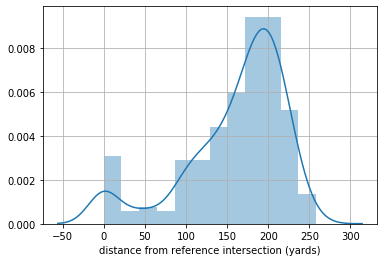

In [6]:
plt.grid()
plt.xlabel("distance from reference intersection (yards)")
sns.distplot(df_out['avg_dist'].values * 1.09361)

In [7]:
a = df_out['avg_dist'].values
q = [10, 20, 25, 30, 50, 75, 80, 90, 99]
np.percentile(a, q)

array([ 74.11931364, 107.58945389, 121.41449691, 130.90677295,
       164.53834559, 186.4617847 , 189.48804602, 200.12720841,
       220.2344265 ])

In [8]:
np.sum(df_out['len_stns'].values)

1630

In [9]:
df_out.head(2)

,uid,cluster_int,len_stns,u_pickups,avg_dist
0,2947,"[2947, 357, 2044, 8011]",4,58491,170.915999
1,1933,"[1933, 8144, 1246, 7815, 7776, 135, 5518]",7,35613,198.597812


In [10]:
dict_cluster = defaultdict(lambda : -18)

for i in range(len(df_out)):
    cluster_id = df_out['uid'][i]
    list1 = df_out['cluster_int'][i]
    for k in list1:
        dict_cluster[k] = cluster_id

In [11]:
df_int2['cluster_id'] = df_int2['unique_intersection_id'].apply(lambda x: dict_cluster[x])
df_int2 = df_int2[df_int2['cluster_id'] != -18]
df_int2 = df_int2.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'])

# add cluster id to the intersections file.
df_int2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1630 entries, 0 to 1998
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   unique_intersection_id  1630 non-null   int64  
 1   INTERSECTIONID          1630 non-null   int64  
 2   FULLINTERSECTION        1630 non-null   object 
 3   LONGITUDE               1630 non-null   float64
 4   LATITUDE                1630 non-null   float64
 5   all_dropoffs            1630 non-null   int64  
 6   all_pickups             1630 non-null   int64  
 7   morning_dropoffs        1630 non-null   int64  
 8   morning_pickups         1630 non-null   int64  
 9   late_morning_dropoffs   1630 non-null   int64  
 10  late_morning_pickups    1630 non-null   int64  
 11  afternoon_dropoffs      1630 non-null   int64  
 12  afternoon_pickups       1630 non-null   int64  
 13  evening_dropoffs        1630 non-null   int64  
 14  evening_pickups         1630 non-null   

C:\Users\akabr\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
df_int2.to_csv("total_pickups_dropoffs_cluster_id_250m_at_intersections.csv")